## Imports

In [92]:
!pip -q install keras-tuner
import keras_tuner as kt

In [91]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    matthews_corrcoef, classification_report, RocCurveDisplay,
    PrecisionRecallDisplay, f1_score, confusion_matrix
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline

SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


# Read the Files

In [ ]:
DATA_PATH = 'data/promoters.data'

df = pd.read_csv(DATA_PATH,
                 sep=',',
                 header=None,
                 names=['Class','Instance_Name','Sequence'])
df.head()

,Class,Instance_Name,Sequence
0,+,S10,\t\ttactagcaatacgcttgcgttcggtggttaagtatgtataat...
1,+,AMPC,\t\ttgctatcctgacagttgtcacgctgattggtgtcgttacaat...
2,+,AROH,\t\tgtactagagaactagtgcattagcttatttttttgttatcat...
3,+,DEOP2,\taattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaa...
4,+,LEU1_TRNA,\ttcgataattaactattgacgaaaagctgaaaaccactagaatgc...


In [12]:
df['Sequence'] = df['Sequence'].str.upper().str.strip()
df['Label'] = df['Class'].map({'+':1, '-':0})
df = df[['Instance_Name', 'Sequence', 'Label']]
df.head()

,Instance_Name,Sequence,Label
0,S10,TACTAGCAATACGCTTGCGTTCGGTGGTTAAGTATGTATAATGCGC...,1
1,AMPC,TGCTATCCTGACAGTTGTCACGCTGATTGGTGTCGTTACAATCTAA...,1
2,AROH,GTACTAGAGAACTAGTGCATTAGCTTATTTTTTTGTTATCATGCTA...,1
3,DEOP2,AATTGTGATGTGTATCGAAGTGTGTTGCGGAGTAGATGTTAGAATA...,1
4,LEU1_TRNA,TCGATAATTAACTATTGACGAAAAGCTGAAAACCACTAGAATGCGC...,1


In [13]:
df['GC_content'] = (
      df['Sequence'].str.count('G') + df['Sequence'].str.count('C')
) / df['Sequence'].str.len()

In [14]:
nt2idx = {'A':0,'C':1,'G':2,'T':3}

def one_hot_encode(seq: str) -> np.ndarray:
    arr = np.zeros((len(seq), 4), dtype=np.float32)
    for i, nt in enumerate(seq):
        j = nt2idx.get(nt, None)
        if j is not None:
            arr[i, j] = 1.0
    return arr

In [15]:
print(f"The dataset has {df.shape[0]} unique sequences and {df.shape[1]} columns.")

The dataset has 106 unique sequences and 4 columns.


In [16]:
df.columns

Index(['Instance_Name', 'Sequence', 'Label', 'GC_content'], dtype='object')

In [17]:
df.describe()

,Label,GC_content
count,106.000000,106.000000
mean,0.500000,0.455975
std,0.502375,0.079590
min,0.000000,0.263158
25%,0.000000,0.403509
50%,0.500000,0.473684
75%,1.000000,0.508772
max,1.000000,0.649123


In [18]:
df['Label'].value_counts()

Label
1    53
0    53
Name: count, dtype: int64

# EDA

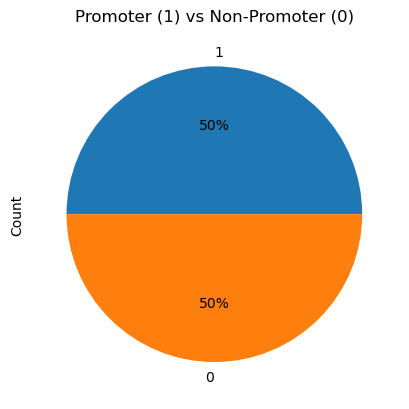

In [19]:
df['Label'].value_counts().plot(kind='pie', title='Promoter (1) vs Non-Promoter (0)', autopct='%0.0f%%')
plt.ylabel('Count')
plt.show()

In [20]:
lengths = df['Sequence'].str.len()
print("Unique lengths:", lengths.unique())

Unique lengths: [57]


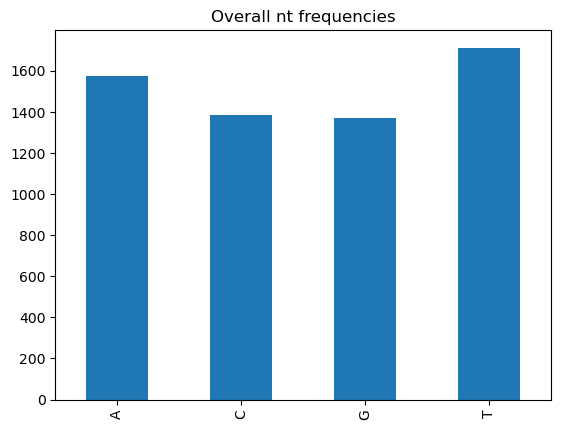

In [21]:
all_nt = ''.join(df['Sequence'])
cnt = Counter(all_nt)
pd.Series(cnt).sort_index().plot(kind='bar', title='Overall nt frequencies')
plt.show()

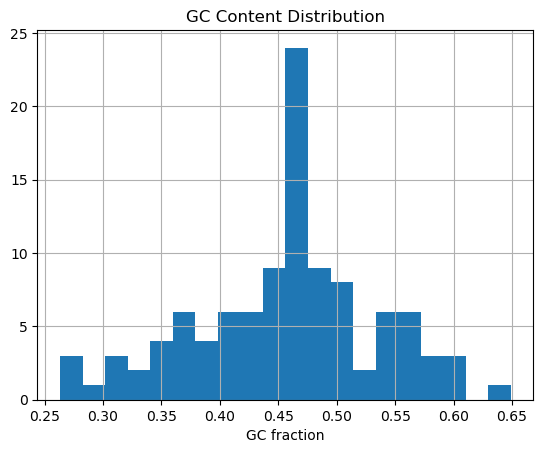

In [22]:
df['GC_content'] = df['Sequence'].apply(lambda s: (s.count('G')+s.count('C'))/len(s))
df['GC_content'].hist(bins=20)
plt.title('GC Content Distribution')
plt.xlabel('GC fraction')
plt.show()


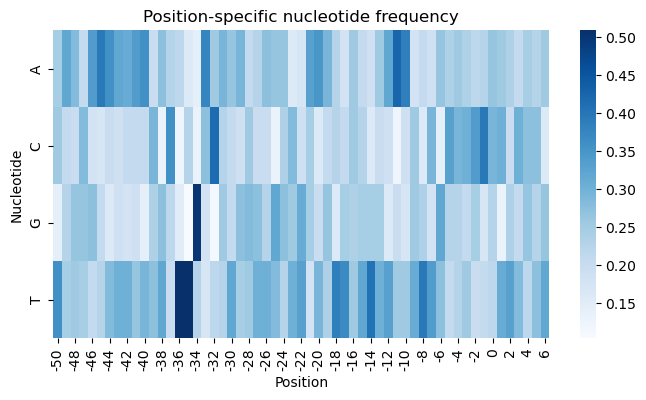

In [23]:
nucs = ["A","C","G","T"]
freq = {n: [] for n in nucs}

for pos in range(57):
    col = df["Sequence"].str[pos]
    counts = col.value_counts().reindex(nucs, fill_value=0)
    for n in nucs:
        freq[n].append(counts[n] / len(df))

freq_df = pd.DataFrame(freq, index=range(-50,7))   # positions in promoter notation
plt.figure(figsize=(8,4))
sns.heatmap(freq_df.T, cmap="Blues")
plt.title("Position-specific nucleotide frequency")
plt.xlabel("Position"); plt.ylabel("Nucleotide")
plt.show()

In [24]:
X = np.stack(df['Sequence'].apply(one_hot_encode).values)
y = df['Label'].values
y = y.astype("float32")

print("X.shape:", X.shape)
print("y.shape:", y.shape)

X.shape: (106, 57, 4)
y.shape: (106,)


# Train/Val/Test Sets

In [25]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=SEED)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (74, 57, 4) Val: (16, 57, 4) Test: (16, 57, 4)


In [26]:
BATCH = 16
def make_ds(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((
    tf.cast(X, tf.float32),
    tf.cast(y, tf.float32)
))
    if shuffle:
        ds = ds.shuffle(len(X), seed=SEED)
    return ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

In [27]:
train_ds = make_ds(X_train, y_train, shuffle=True)
val_ds   = make_ds(X_val,   y_val)
test_ds  = make_ds(X_test,  y_test)

In [28]:
for xb, yb in train_ds.take(1):
    print(xb.shape, yb.shape)

(16, 57, 4) (16,)


2025-08-05 20:32:40.809265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# 1-D CNN Model

In [29]:
def build_tiny_cnn(hp):
    inputs = keras.Input(shape=(57, 4))

    f1 = hp.Choice("filters_1", [32, 64], default=32)
    f2 = hp.Choice("filters_2", [64, 128], default=64)

    x = layers.Conv1D(f1, kernel_size=5, padding="same", activation="relu")(inputs)
    x = layers.Conv1D(f2, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.GlobalMaxPooling1D()(x)

    drop = hp.Choice("dropout", [0.2, 0.3, 0.5], default=0.3)
    x = layers.Dropout(drop)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model_cnn = keras.Model(inputs, outputs, name="tiny_cnn")

    lr = hp.Choice("lr", [1e-3, 5e-4, 3e-4], default=1e-3)
    model_cnn.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.AUC(name="auroc", curve="ROC"),
            keras.metrics.AUC(name="auprc", curve="PR")
        ],
    )
    return model_cnn

In [30]:
tuner = kt.RandomSearch(
    build_tiny_cnn,
    objective=kt.Objective("val_auprc", direction="max"),
    max_trials=12,
    seed=42,
    directory="kt_logs",
    project_name="tiny_cnn_search",
    overwrite=True,
)

tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[keras.callbacks.EarlyStopping(
        monitor="val_auprc", mode="max", patience=6)],
    verbose=2
)

Trial 12 Complete [00h 00m 05s]
val_auprc: 1.0

Best val_auprc So Far: 1.0
Total elapsed time: 00h 00m 50s


In [31]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyper-params:", best_hp.values)

Best hyper-params: {'filters_1': 32, 'filters_2': 64, 'dropout': 0.2, 'lr': 0.0005}


In [32]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_auprc", mode="max", patience=10, restore_best_weights=True
    )
]

In [33]:
baseline_cnn = build_tiny_cnn(best_hp)
history = baseline_cnn.fit(
    train_ds, epochs=40, validation_data=val_ds,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/40
5/5 - 2s - 400ms/step - accuracy: 0.4189 - auprc: 0.4220 - auroc: 0.3758 - loss: 0.7100 - val_accuracy: 0.5000 - val_auprc: 0.5695 - val_auroc: 0.5469 - val_loss: 0.6919
Epoch 2/40
5/5 - 0s - 9ms/step - accuracy: 0.5811 - auprc: 0.5459 - auroc: 0.5690 - loss: 0.6878 - val_accuracy: 0.6875 - val_auprc: 0.6392 - val_auroc: 0.5781 - val_loss: 0.6888
Epoch 3/40
5/5 - 0s - 9ms/step - accuracy: 0.5405 - auprc: 0.5769 - auroc: 0.5800 - loss: 0.6863 - val_accuracy: 0.6875 - val_auprc: 0.7039 - val_auroc: 0.6484 - val_loss: 0.6852
Epoch 4/40
5/5 - 0s - 9ms/step - accuracy: 0.5000 - auprc: 0.5518 - auroc: 0.5442 - loss: 0.6869 - val_accuracy: 0.6250 - val_auprc: 0.7571 - val_auroc: 0.7109 - val_loss: 0.6817
Epoch 5/40
5/5 - 0s - 9ms/step - accuracy: 0.6622 - auprc: 0.7387 - auroc: 0.7421 - loss: 0.6615 - val_accuracy: 0.6875 - val_auprc: 0.8283 - val_auroc: 0.8203 - val_loss: 0.6787
Epoch 6/40
5/5 - 0s - 9ms/step - accuracy: 0.5405 - auprc: 0.6034 - auroc: 0.5928 - loss: 0.6804 - val_

In [34]:
baseline_val_acc = history.history['val_accuracy'][-1]
baseline_val_auc = history.history['val_auprc'][-1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
              precision    recall  f1-score   support

         0.0      1.000     1.000     1.000         8
         1.0      1.000     1.000     1.000         8

    accuracy                          1.000        16
   macro avg      1.000     1.000     1.000        16
weighted avg      1.000     1.000     1.000        16



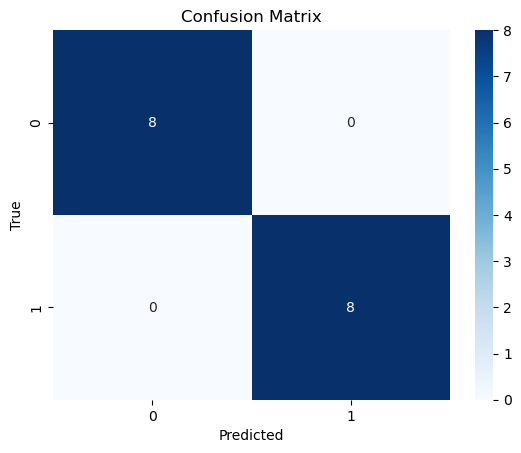

In [35]:
y_prob_cnn = baseline_cnn.predict(test_ds).ravel()
y_pred_cnn = (y_prob_cnn > 0.5).astype(int)

print(classification_report(y_test, y_pred_cnn, digits=3))

cm = confusion_matrix(y_test, y_pred_cnn)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix"); plt.show()


In [36]:
history_dict = history.history
epochs = range(1, len(history_dict["loss"]) + 1)

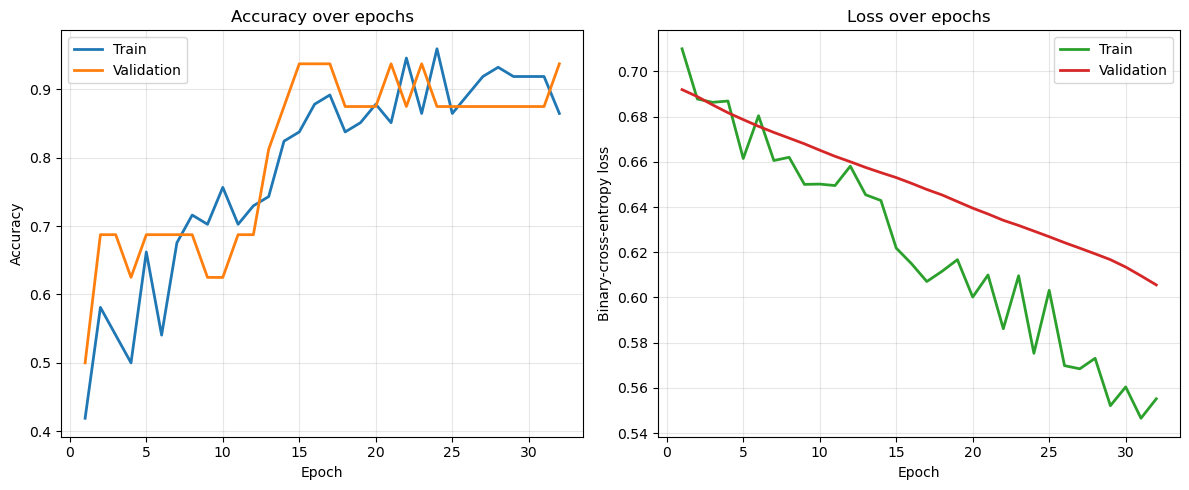

In [37]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict["accuracy"],        label="Train", color="tab:blue",  linewidth=2)
plt.plot(epochs, history_dict["val_accuracy"],    label="Validation", color="tab:orange", linewidth=2)
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict["loss"],            label="Train", color="tab:green", linewidth=2)
plt.plot(epochs, history_dict["val_loss"],        label="Validation", color="tab:red",   linewidth=2)
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Binary-cross-entropy loss")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [38]:
res = [
    {
        "Model"   : "Baseline CNN",
        "Accuracy": accuracy_score(y_test, y_pred_cnn),
        "AUROC"   : roc_auc_score(y_test, y_prob_cnn),
        "AUPRC"   : average_precision_score(y_test, y_prob_cnn),
        "F1-Score": f1_score(y_test, y_pred_cnn),
    }
]

results = pd.DataFrame(res).set_index("Model")
display(results.style.format("{:.3f}"))

,Accuracy,AUROC,AUPRC,F1-Score
Model,,,,
Baseline CNN,1.000,1.000,1.000,1.000


# Data Augmentation & Re-Split

In [39]:
complement = str.maketrans("ACGT", "TGCA")

def revcomp(seq: str) -> str:
    return seq.translate(complement)[::-1]

In [40]:
aug_rows = []
for _, row in df.iterrows():
    rc = revcomp(row.Sequence)
    aug_rows.append({"Instance_Name": row.Instance_Name+"_rc",
                     "Sequence": rc,
                     "Label": row.Label})

df_aug = pd.concat([df, pd.DataFrame(aug_rows)], ignore_index=True)
print("After reverse-complement:", df_aug.shape)

After reverse-complement: (212, 4)


In [41]:
def noisy(seq, n_mut=3):
    seq = list(seq)
    idx = np.random.choice(len(seq), size=n_mut, replace=False)
    nts = np.random.choice(list("ACGT"), size=n_mut)
    for i, nt in zip(idx, nts):
        seq[i] = nt
    return "".join(seq)

In [42]:
mut_rows = []
for _, row in df_aug.iterrows():
    mut_rows.append({"Instance_Name": row.Instance_Name+"_mut",
                     "Sequence": noisy(row.Sequence),
                     "Label": row.Label})
df_aug = pd.concat([df_aug, pd.DataFrame(mut_rows)], ignore_index=True)
print("After noisy augmentation:", df_aug.shape)

After noisy augmentation: (424, 4)


In [43]:
X_all = np.stack(df_aug['Sequence'].apply(one_hot_encode).values).astype('float32')
y_all = df_aug['Label'].values.astype('float32')

In [44]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.30, stratify=y_all, random_state=SEED)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (296, 57, 4) Val: (64, 57, 4) Test: (64, 57, 4)


In [45]:
train_ds = make_ds(X_train, y_train, shuffle=True)
val_ds   = make_ds(X_val,   y_val)
test_ds  = make_ds(X_test,  y_test)

# CNN + Bi-LSTM

In [46]:
def build_cnn_bilstm(hp):
    """Tunable CNN + BiLSTM builder."""
    inputs = keras.Input(shape=(57, 4))

    f1 = hp.Choice("filters_1", [64],              default=64)
    f2 = hp.Choice("filters_2", [128, 192],        default=128)

    x  = layers.Conv1D(f1, 7, padding="same", activation="relu")(inputs)
    x  = layers.BatchNormalization()(x)
    x  = layers.Conv1D(f2, 5, padding="same", activation="relu")(x)
    x  = layers.MaxPool1D(2)(x)

    lstm_units = hp.Choice("lstm_units", [64, 128, 256], default=128)
    x  = layers.Bidirectional(
            layers.LSTM(lstm_units, return_sequences=True))(x)

    e = layers.Dense(1, activation="tanh")(x)
    a = layers.Flatten()(e)
    a = layers.Activation("softmax")(a)
    a = layers.Reshape((-1,1))(a)
    x = layers.Multiply()([x, a])
    x = layers.Lambda(lambda t: tf.reduce_sum(t, axis=1))(x)

    drop = hp.Choice("dropout", [0.2, 0.3, 0.5], default=0.3)
    x = layers.Dropout(drop)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="cnn_bilstm")

    lr = hp.Choice("lr", [1e-3, 5e-4, 3e-4], default=1e-3)
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.AUC(name="auc"),
            keras.metrics.AUC(curve="PR", name="aupr"),
            "accuracy",
        ],
    )
    return model


In [47]:
tuner_bilstm = kt.RandomSearch(
    build_cnn_bilstm,
    objective   = kt.Objective("val_aupr", direction="max"),
    max_trials  = 18,
    seed        = 42,
    directory   = "kt_logs",
    project_name= "bilstm_search",
    overwrite   = True,
)

tuner_bilstm.search(
    train_ds,
    validation_data = val_ds,
    epochs          = 40,
    callbacks=[keras.callbacks.EarlyStopping(
        monitor="val_auprc", mode="max", patience=6)],    
    verbose         = 2
)

Trial 18 Complete [00h 00m 25s]
val_aupr: 1.0

Best val_aupr So Far: 1.0
Total elapsed time: 00h 10m 25s


In [48]:
best_hp = tuner_bilstm.get_best_hyperparameters(1)[0]
print("Best hyper-params:", best_hp.values)

Best hyper-params: {'filters_1': 64, 'filters_2': 128, 'lstm_units': 128, 'dropout': 0.2, 'lr': 0.0003}


In [49]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_aupr",
    mode="max",
    patience=8,
    restore_best_weights=True,
)

In [50]:
ckpt = keras.callbacks.ModelCheckpoint(
    "cnn_bilstm_best.weights.h5",
    monitor="val_aupr",
    mode="max",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

In [51]:
model_bilstm = build_cnn_bilstm(best_hp)
history = model_bilstm.fit(
    train_ds,
    epochs          = 50,
    validation_data = val_ds,
    callbacks       = [early_stop, ckpt],
    verbose         = 2,
)


Epoch 1/50

Epoch 1: val_aupr improved from None to 0.77564, saving model to cnn_bilstm_best.weights.h5
19/19 - 8s - 405ms/step - accuracy: 0.4831 - auc: 0.5100 - aupr: 0.5518 - loss: 0.7222 - val_accuracy: 0.5000 - val_auc: 0.7251 - val_aupr: 0.7756 - val_loss: 0.6894
Epoch 2/50

Epoch 2: val_aupr did not improve from 0.77564
19/19 - 0s - 25ms/step - accuracy: 0.7061 - auc: 0.7892 - aupr: 0.7953 - loss: 0.5962 - val_accuracy: 0.6250 - val_auc: 0.7476 - val_aupr: 0.7749 - val_loss: 0.6786
Epoch 3/50

Epoch 3: val_aupr improved from 0.77564 to 0.81599, saving model to cnn_bilstm_best.weights.h5
19/19 - 1s - 32ms/step - accuracy: 0.8041 - auc: 0.8704 - aupr: 0.8985 - loss: 0.4739 - val_accuracy: 0.7031 - val_auc: 0.8013 - val_aupr: 0.8160 - val_loss: 0.6557
Epoch 4/50

Epoch 4: val_aupr improved from 0.81599 to 0.89120, saving model to cnn_bilstm_best.weights.h5
19/19 - 1s - 29ms/step - accuracy: 0.8885 - auc: 0.9346 - aupr: 0.9413 - loss: 0.3317 - val_accuracy: 0.7812 - val_auc: 0.8936 

In [52]:
bilstm_val_acc = history.history['val_accuracy'][-1]
bilstm_val_auc = history.history['val_aupr'][-1]

## Evaluation

In [53]:
y_prob_bilstm = model_bilstm.predict(test_ds).ravel()
y_pred_bilstm = (y_prob_bilstm > 0.5).astype(int)

print(classification_report(y_test, y_pred_bilstm, digits=3))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step 
              precision    recall  f1-score   support

         0.0      0.968     0.938     0.952        32
         1.0      0.939     0.969     0.954        32

    accuracy                          0.953        64
   macro avg      0.954     0.953     0.953        64
weighted avg      0.954     0.953     0.953        64



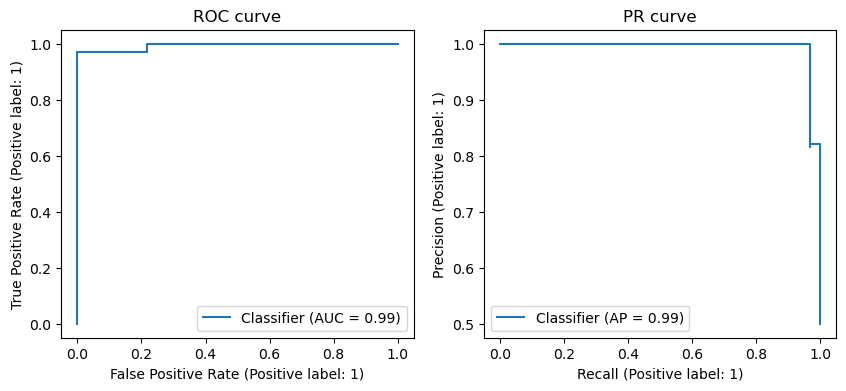

In [54]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
RocCurveDisplay.from_predictions(y_test, y_prob_bilstm, ax=ax1)
ax1.set_title("ROC curve")
PrecisionRecallDisplay.from_predictions(y_test, y_prob_bilstm, ax=ax2)
ax2.set_title("PR curve")
plt.show()

In [55]:
hist   = history.history
epochs = range(1, len(hist["loss"]) + 1)

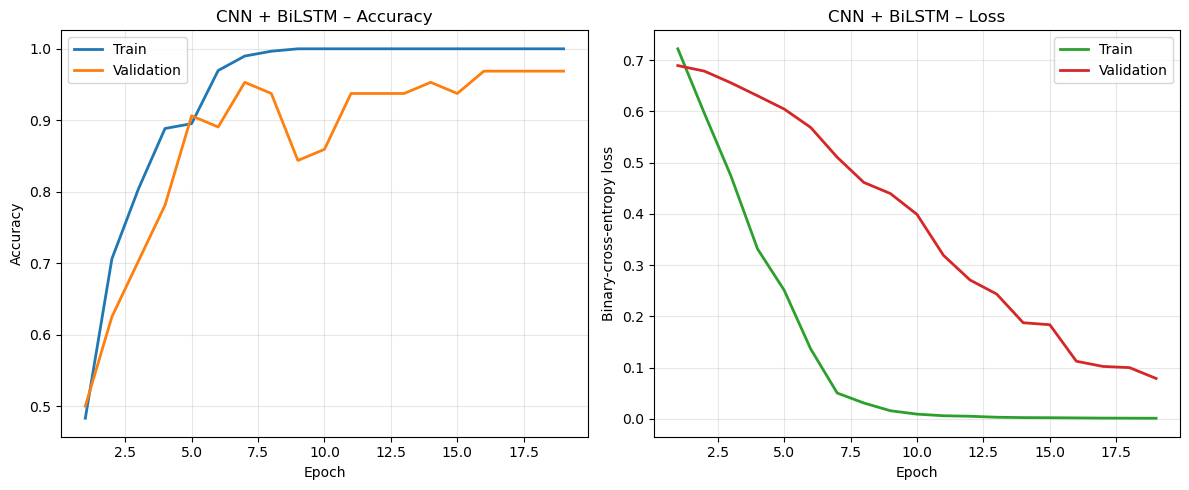

In [56]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, hist["accuracy"],     label="Train",      color="tab:blue",  linewidth=2)
plt.plot(epochs, hist["val_accuracy"], label="Validation", color="tab:orange",linewidth=2)
plt.title("CNN + BiLSTM – Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs, hist["loss"],     label="Train",      color="tab:green", linewidth=2)
plt.plot(epochs, hist["val_loss"], label="Validation", color="tab:red",   linewidth=2)
plt.title("CNN + BiLSTM – Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary-cross-entropy loss")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Inception-style multi-kernel CNN

In [57]:
def inception_block(x, filters):
    branches = []
    for k in (3,5,7):
        b = layers.Conv1D(filters, k, padding="same", activation="relu")(x)
        branches.append(b)
    return layers.concatenate(branches, axis=-1)

In [58]:
def build_inception(hp):
    inputs = keras.Input(shape=(57,4))

    f1 = hp.Choice("filters_block1", [32, 48], default=32)
    f2 = hp.Choice("filters_block2", [64, 96], default=64)

    x  = inception_block(inputs, f1)
    x  = layers.BatchNormalization()(x)
    x  = inception_block(x, f2)
    x  = layers.GlobalMaxPooling1D()(x)

    drop = hp.Choice("dropout", [0.2, 0.3, 0.5], default=0.3)
    x  = layers.Dropout(drop)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name="inception_cnn")

    lr = hp.Choice("lr", [1e-3, 5e-4, 3e-4], default=1e-3)

    model.compile(
        optimizer = keras.optimizers.Adam(lr),
        loss      = "binary_crossentropy",
        metrics   = [keras.metrics.AUC(name="auc"),
                     keras.metrics.AUC(curve='PR', name='aupr'),
                     "accuracy"]
    )
    return model

In [59]:
tuner_incep = kt.RandomSearch(
    build_inception,
    objective    = kt.Objective("val_aupr", direction="max"),
    max_trials   = 18,
    seed         = 42,
    directory    = "kt_logs",
    project_name = "incep_search",
    overwrite    = True,
)

tuner_incep.search(
    train_ds,
    validation_data = val_ds,
    epochs          = 40,
    callbacks       = callbacks,
    verbose         = 2
)

Trial 18 Complete [00h 00m 29s]
val_aupr: 1.0

Best val_aupr So Far: 1.0
Total elapsed time: 00h 06m 42s


In [60]:
best_hp_incep = tuner_incep.get_best_hyperparameters(1)[0]
print("Best hyper-params:", best_hp_incep.values)

Best hyper-params: {'filters_block1': 48, 'filters_block2': 64, 'dropout': 0.3, 'lr': 0.001}


In [61]:
model_incep = build_inception(best_hp_incep)

callbacks[0].patience = 6

history_incep = model_incep.fit(
    train_ds,
    epochs          = 50,
    validation_data = val_ds,
    callbacks       = callbacks,
    verbose         = 2
)

Epoch 1/50
19/19 - 7s - 354ms/step - accuracy: 0.6318 - auc: 0.6744 - aupr: 0.6711 - loss: 0.9780 - val_accuracy: 0.8281 - val_auc: 0.9873 - val_aupr: 0.9901 - val_loss: 0.5899
Epoch 2/50
19/19 - 0s - 20ms/step - accuracy: 0.8446 - auc: 0.9279 - aupr: 0.9132 - loss: 0.3651 - val_accuracy: 0.9531 - val_auc: 0.9907 - val_aupr: 0.9920 - val_loss: 0.5325
Epoch 3/50
19/19 - 0s - 19ms/step - accuracy: 0.8784 - auc: 0.9590 - aupr: 0.9628 - loss: 0.2785 - val_accuracy: 0.9844 - val_auc: 0.9985 - val_aupr: 0.9986 - val_loss: 0.4850
Epoch 4/50
19/19 - 0s - 18ms/step - accuracy: 0.9493 - auc: 0.9868 - aupr: 0.9883 - loss: 0.1467 - val_accuracy: 0.9844 - val_auc: 0.9990 - val_aupr: 0.9990 - val_loss: 0.4419
Epoch 5/50
19/19 - 0s - 18ms/step - accuracy: 0.9358 - auc: 0.9822 - aupr: 0.9766 - loss: 0.1742 - val_accuracy: 0.9375 - val_auc: 0.9995 - val_aupr: 0.9995 - val_loss: 0.4203
Epoch 6/50
19/19 - 0s - 18ms/step - accuracy: 0.9561 - auc: 0.9918 - aupr: 0.9916 - loss: 0.1133 - val_accuracy: 0.9219

In [62]:
incep_val_acc = history_incep.history['val_accuracy'][-1]
incep_val_auc = history_incep.history['val_aupr'][-1]

## Evaluation

In [63]:
y_prob_incep = model_incep.predict(test_ds).ravel()
y_pred_incep = (y_prob_incep > 0.5).astype(int)

print(classification_report(y_test, y_pred_incep, digits=3))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
              precision    recall  f1-score   support

         0.0      0.970     1.000     0.985        32
         1.0      1.000     0.969     0.984        32

    accuracy                          0.984        64
   macro avg      0.985     0.984     0.984        64
weighted avg      0.985     0.984     0.984        64



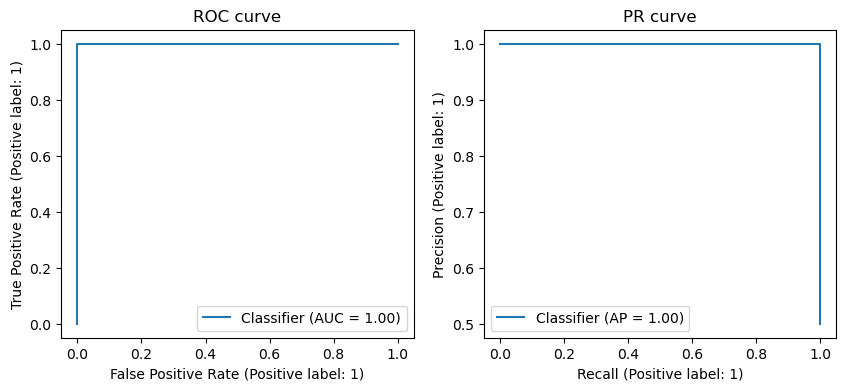

In [64]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
RocCurveDisplay.from_predictions(y_test, y_prob_incep, ax=ax1)
ax1.set_title("ROC curve")
PrecisionRecallDisplay.from_predictions(y_test, y_prob_incep, ax=ax2)
ax2.set_title("PR curve")
plt.show()

In [65]:
hist   = history.history
epochs = range(1, len(hist["loss"]) + 1)

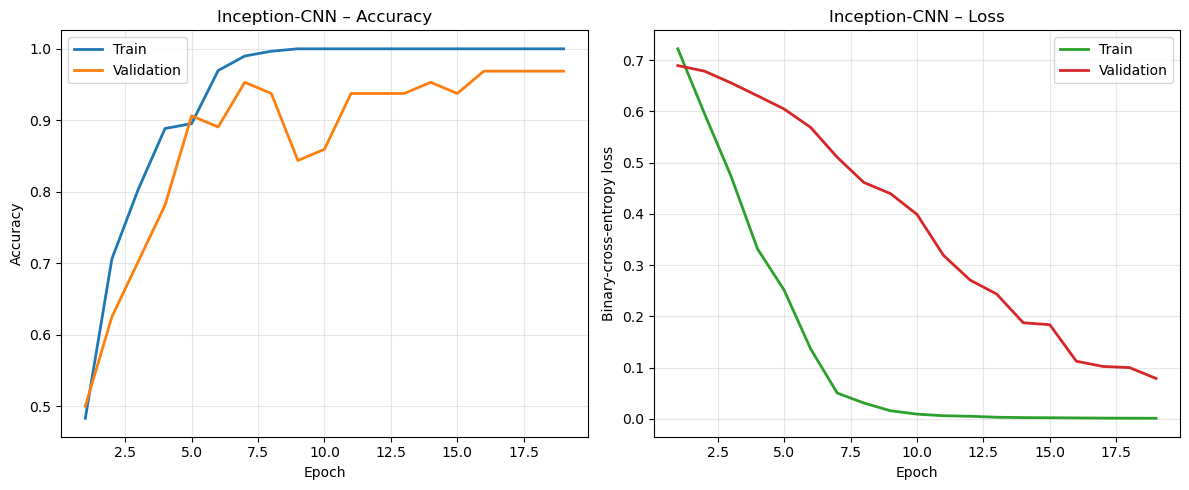

In [66]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, hist["accuracy"],     label="Train",      color="tab:blue",   linewidth=2)
plt.plot(epochs, hist["val_accuracy"], label="Validation", color="tab:orange", linewidth=2)
plt.title("Inception-CNN – Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs, hist["loss"],     label="Train",      color="tab:green", linewidth=2)
plt.plot(epochs, hist["val_loss"], label="Validation", color="tab:red",   linewidth=2)
plt.title("Inception-CNN – Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary-cross-entropy loss")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
model_bilstm.save_weights("models/cnn_bilstm_best.weights.h5")
model_incep.save_weights("models/inception_best.weights.h5")

In [68]:
more_res = [
    {
        "Model"   : "CNN + BiLSTM",
        "Accuracy": accuracy_score(y_test, y_pred_bilstm),
        "AUROC"   : roc_auc_score(y_test, y_prob_bilstm),
        "AUPRC"   : average_precision_score(y_test, y_prob_bilstm),
        "F1-Score": f1_score(y_test, y_pred_bilstm),
    },
    {
        "Model"   : "Inception CNN",
        "Accuracy": accuracy_score(y_test, y_pred_incep),
        "AUROC"   : roc_auc_score(y_test, y_prob_incep),
        "AUPRC"   : average_precision_score(y_test, y_prob_incep),
        "F1-Score": f1_score(y_test, y_pred_incep),
    },
]

results = pd.concat(
    [results, pd.DataFrame(more_res).set_index("Model")],
    axis=0
)

display(results.style.format("{:.3f}"))


,Accuracy,AUROC,AUPRC,F1-Score
Model,,,,
Baseline CNN,1.000,1.000,1.000,1.000
CNN + BiLSTM,0.953,0.993,0.994,0.954
Inception CNN,0.984,1.000,1.000,0.984


# Simple Transformer

## Transformer Encoder

In [69]:
def build_tiny_transformer(
        embed_dim=32, num_heads=4, ff_dim=64, drop=0.2) -> keras.Model:

    inputs = keras.Input(shape=(57,4))
    x = layers.Dense(embed_dim)(inputs)
    pos = tf.range(start=0, limit=57, delta=1)
    pos_emb = layers.Embedding(input_dim=57, output_dim=embed_dim)(pos)
    x = x + pos_emb

    for _ in range(2):
        attn = layers.MultiHeadAttention(num_heads, key_dim=embed_dim)(x,x)
        x = layers.Add()([x, attn])
        x = layers.LayerNormalization()(x)
        ff  = layers.Dense(ff_dim, activation="relu")(x)
        ff  = layers.Dense(embed_dim)(ff)
        x = layers.Add()([x, ff])
        x = layers.LayerNormalization()(x)

    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(drop)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="tiny_transformer")
    model.compile(
        optimizer=keras.optimizers.Adam(2e-3),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.AUC(name="auc"),
            keras.metrics.AUC(curve="PR", name="aupr"),
            "accuracy",
        ],
    )
    return model

In [70]:
def build_tiny_transformer_tunable(hp):
    inputs = keras.Input(shape=(57,4))

    embed_dim = hp.Choice("embed_dim", [32, 64, 96], default=32)
    num_heads = hp.Choice("num_heads", [4, 6], default=4)
    ff_dim    = hp.Choice("ff_dim",    [64, 128, 192], default=64)

    x = layers.Dense(embed_dim)(inputs)
    pos = tf.range(57)
    pos_emb = layers.Embedding(57, embed_dim)(pos)
    x = x + pos_emb

    for _ in range(2):
        att = layers.MultiHeadAttention(num_heads, key_dim=embed_dim)(x,x)
        x   = layers.LayerNormalization()(x + att)
        ff  = layers.Dense(ff_dim, activation="relu")(x)
        ff  = layers.Dense(embed_dim)(ff)
        x   = layers.LayerNormalization()(x + ff)

    drop = hp.Choice("dropout", [0.2, 0.3, 0.5], default=0.2)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(drop)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name="tiny_transformer")

    lr = hp.Choice("lr", [2e-3, 1e-3, 5e-4], default=2e-3)
    model.compile(
        optimizer = keras.optimizers.Adam(lr),
        loss      = "binary_crossentropy",
        metrics   = [keras.metrics.AUC(name="auc"),
                     keras.metrics.AUC(curve="PR", name="aupr"),
                     "accuracy"],
    )
    return model

In [71]:
tuner_trans = kt.RandomSearch(
    build_tiny_transformer_tunable,
    objective    = kt.Objective("val_aupr", direction="max"),
    max_trials   = 15,
    seed         = 42,
    directory    = "kt_logs",
    project_name = "trans_search",
    overwrite    = True,
)

tuner_trans.search(
    train_ds,
    validation_data = val_ds,
    epochs          = 40,
    callbacks       = [keras.callbacks.EarlyStopping(
                          monitor="val_aupr", mode="max",
                          patience=6, restore_best_weights=True)],
    verbose         = 2
)

Trial 15 Complete [00h 00m 19s]
val_aupr: 0.7184962630271912

Best val_aupr So Far: 0.968467652797699
Total elapsed time: 00h 07m 01s


In [72]:
best_hp_trans = tuner_trans.get_best_hyperparameters(1)[0]
print("Best hyper-params:", best_hp_trans.values)

Best hyper-params: {'embed_dim': 96, 'num_heads': 6, 'ff_dim': 192, 'dropout': 0.2, 'lr': 0.0005}


## 10-fold CV

In [73]:
def cv_evaluate(X, y, build_fn, n_splits=10, batch=16):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    metrics = {"acc":[], "auc":[], "aupr":[], "mcc":[]}

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        model = build_fn()
        early = keras.callbacks.EarlyStopping(
            monitor="val_aupr", mode="max", patience=6,
            restore_best_weights=True, verbose=0)

        model.fit(
            X[train_idx], y[train_idx],
            validation_data=(X[val_idx], y[val_idx]),
            epochs=40, batch_size=batch, verbose=0,
            callbacks=[early]
        )

        prob = model.predict(X[val_idx], batch_size=batch).ravel()
        pred = (prob>0.5).astype(int); true = y[val_idx]

        metrics["acc"].append(accuracy_score(true, pred))
        metrics["auc"].append(roc_auc_score(true, prob))
        metrics["aupr"].append(average_precision_score(true, prob))
        metrics["mcc"].append(matthews_corrcoef(true, pred))

        print(f"fold {fold:2d}  "
              f"acc {metrics['acc'][-1]:.3f}  "
              f"roc_auc {metrics['auc'][-1]:.3f}  "
              f"pr_auc {metrics['aupr'][-1]:.3f}")

    return {k:(np.mean(v), np.std(v)) for k,v in metrics.items()}

In [75]:
def build_fixed_transformer():
    return build_tiny_transformer_tunable(best_hp_trans)

In [76]:
results_trans_tuned = cv_evaluate(X_all, y_all, build_fixed_transformer)
print("\nTUNED Transformer 10-fold results")
for k,(mean,std) in results_trans_tuned.items():
    print(f"{k:4s}: {mean:.3f} ± {std:.3f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step
fold  1  acc 0.953  roc_auc 0.998  pr_auc 0.998
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/stepWARNING:tensorflow:6 out of the last 14 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x1a0dd1800> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step
fold  2  acc 0.977  roc_auc 1.000  pr_auc 1.000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step
fold  3  acc 0.930  roc_auc 1

In [74]:
X_tv = np.concatenate([X_train, X_val]).astype("float32")
y_tv = np.concatenate([y_train, y_val]).astype("float32")

## Model

In [78]:
simple_trans = build_tiny_transformer_tunable(best_hp_trans)
history = simple_trans.fit(X_tv, y_tv,
                          validation_data=(X_test, y_test),
                          epochs=40, batch_size=16,
                          callbacks=[keras.callbacks.EarlyStopping(
                              monitor="val_aupr", mode="max", patience=8,
                              restore_best_weights=True)],
                              verbose=2
                              )

Epoch 1/40
23/23 - 17s - 723ms/step - accuracy: 0.5833 - auc: 0.5905 - aupr: 0.5716 - loss: 0.7596 - val_accuracy: 0.6875 - val_auc: 0.8281 - val_aupr: 0.8402 - val_loss: 0.5658
Epoch 2/40
23/23 - 2s - 82ms/step - accuracy: 0.6694 - auc: 0.7148 - aupr: 0.7332 - loss: 0.6362 - val_accuracy: 0.6875 - val_auc: 0.7856 - val_aupr: 0.8056 - val_loss: 0.5635
Epoch 3/40
23/23 - 2s - 91ms/step - accuracy: 0.6667 - auc: 0.7183 - aupr: 0.7379 - loss: 0.6293 - val_accuracy: 0.6875 - val_auc: 0.8115 - val_aupr: 0.8311 - val_loss: 0.5654
Epoch 4/40
23/23 - 2s - 89ms/step - accuracy: 0.6472 - auc: 0.7290 - aupr: 0.7634 - loss: 0.6163 - val_accuracy: 0.6094 - val_auc: 0.8257 - val_aupr: 0.8346 - val_loss: 0.6610
Epoch 5/40
23/23 - 2s - 101ms/step - accuracy: 0.6611 - auc: 0.7376 - aupr: 0.7660 - loss: 0.5940 - val_accuracy: 0.6406 - val_auc: 0.8452 - val_aupr: 0.8505 - val_loss: 0.5749
Epoch 6/40
23/23 - 2s - 78ms/step - accuracy: 0.6833 - auc: 0.7703 - aupr: 0.7917 - loss: 0.5660 - val_accuracy: 0.68

In [79]:
y_prob_trans = simple_trans.predict(X_test).ravel()
y_pred_trans = (y_prob_trans>0.5).astype(int)

print(classification_report(y_test, y_pred_trans, digits=3))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
              precision    recall  f1-score   support

         0.0      0.968     0.938     0.952        32
         1.0      0.939     0.969     0.954        32

    accuracy                          0.953        64
   macro avg      0.954     0.953     0.953        64
weighted avg      0.954     0.953     0.953        64



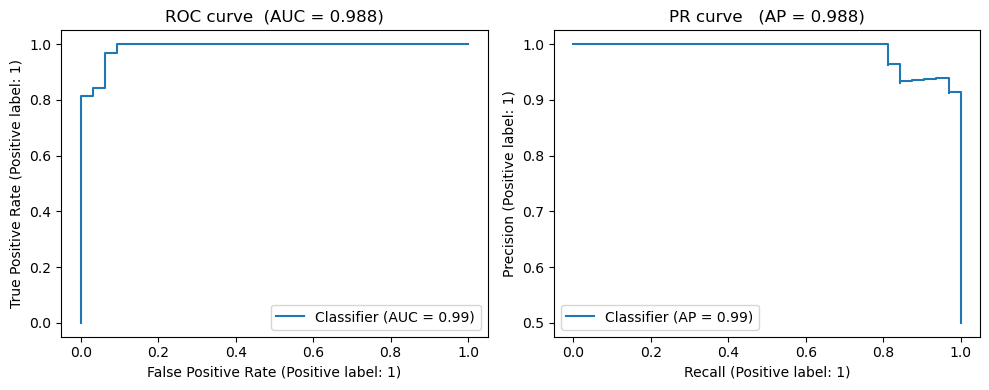

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

RocCurveDisplay.from_predictions(
    y_test, y_prob_trans, ax=ax[0])
ax[0].set_title(f"ROC curve  (AUC = {roc_auc_score(y_test, y_prob_trans):.3f})")

PrecisionRecallDisplay.from_predictions(
    y_test, y_prob_trans, ax=ax[1])
ax[1].set_title(f"PR curve   (AP = {average_precision_score(y_test, y_prob_trans):.3f})")

plt.tight_layout()
plt.show()

In [81]:
hist   = history.history
epochs = range(1, len(hist["loss"]) + 1)

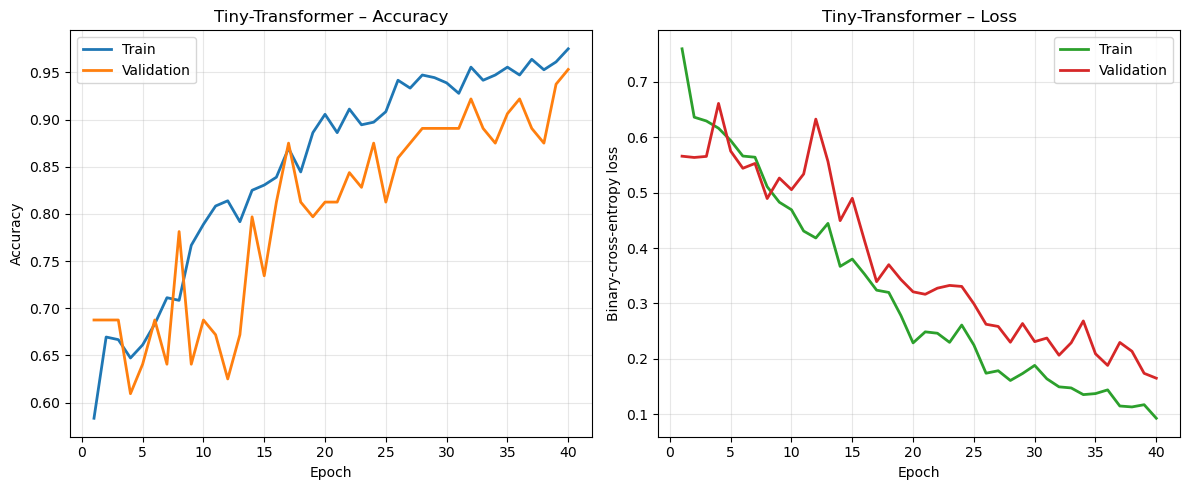

In [82]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, hist["accuracy"],     label="Train",      color="tab:blue",   linewidth=2)
plt.plot(epochs, hist["val_accuracy"], label="Validation", color="tab:orange", linewidth=2)
plt.title("Tiny-Transformer – Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs, hist["loss"],     label="Train",      color="tab:green", linewidth=2)
plt.plot(epochs, hist["val_loss"], label="Validation", color="tab:red",   linewidth=2)
plt.title("Tiny-Transformer – Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary-cross-entropy loss")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
simple_trans.save_weights("models/simple_transformer_best.weights.h5")

In [86]:
extra_res = [
    {
        "Model"   : "Simple Transformer",
        "Accuracy": accuracy_score(y_test, y_pred_trans),
        "AUROC"   : roc_auc_score(y_test, y_prob_trans),
        "AUPRC"   : average_precision_score(y_test, y_prob_trans),
        "F1-Score": f1_score(y_test, y_pred_trans),
    },
]

In [87]:
results = pd.concat(
    [results, pd.DataFrame(extra_res).set_index("Model")],
    axis=0
)

display(results.style.format("{:.3f}"))


,Accuracy,AUROC,AUPRC,F1-Score
Model,,,,
Baseline CNN,1.000,1.000,1.000,1.000
CNN + BiLSTM,0.953,0.993,0.994,0.954
Inception CNN,0.984,1.000,1.000,0.984
Simple Transformer,0.953,0.988,0.988,0.954


# Integrated Gradient Heatmap

In [89]:
def integrated_gradients(model, inputs, baseline=None, steps=50):
    if baseline is None:
        baseline = tf.zeros_like(inputs)
    alphas = tf.linspace(0.0, 1.0, steps+1)

    grads = []
    for a in alphas:
        with tf.GradientTape() as tape:
            tape.watch(inputs)
            out = model(baseline + a*(inputs - baseline), training=False)
            out = tf.squeeze(out, axis=-1)
        grads.append(tape.gradient(out, inputs))
    grads = tf.stack(grads)
    avg_grads = tf.reduce_mean(grads[:-1], axis=0)
    return (inputs - baseline) * avg_grads

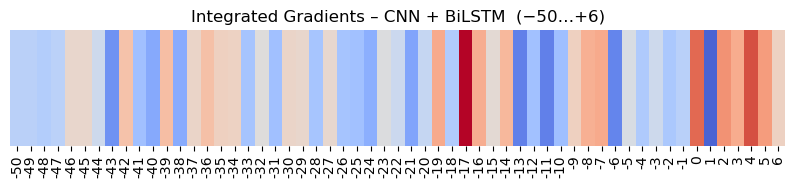

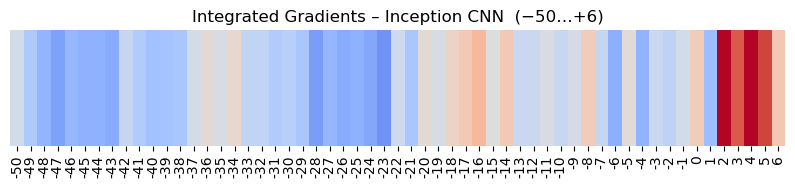

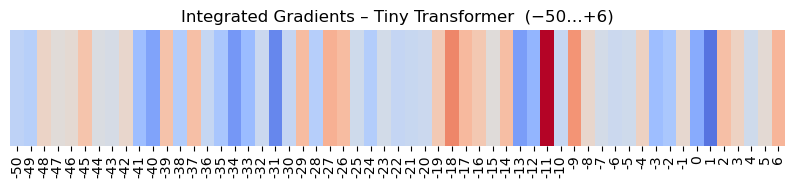

In [90]:
models = {
    "CNN + BiLSTM":   model_bilstm,
    "Inception CNN":  model_incep,
    "Tiny Transformer": simple_trans
}

sample = tf.convert_to_tensor(X_test[:1], dtype=tf.float32)

for name, mdl in models.items():
    attr   = integrated_gradients(mdl, sample, steps=50)[0]
    scores = tf.reduce_sum(attr, axis=1).numpy()
    plt.figure(figsize=(10,1.5))
    sns.heatmap(scores[np.newaxis, :],
                cmap='coolwarm', center=0,
                xticklabels=range(-50,7), cbar=False)
    plt.title(f'Integrated Gradients – {name}  (−50…+6)')
    plt.yticks([])
    plt.show()
